<a href="https://colab.research.google.com/github/ujs/PORTFOLIO/blob/master/CIFAR10_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing libraries
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import regularizers

In [32]:
#importing data
from keras.datasets import cifar10

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del x, y
   del x_test, y_test
   print('Clear previously loaded data.')
except:
   pass

#load data
(x, y),(x_test, y_test) = cifar10.load_data()



# As a sanity check, print out the size of the training and test data.
print('Training data shape: ', x.shape)
print('Training labels shape: ', y.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


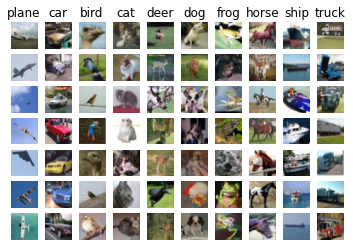

In [33]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(y == i)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(idxs):
        plt_idx = j * num_classes + i + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x[idx].astype('uint8'))
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

In [34]:
#Splitting x,y data into train and validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
#Data Preprocessing

#Rescaling image pixels
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#One Hot Encoding of Categorical labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



In [0]:
#Data Augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train,y_train, batch_size = 64)

In [37]:
#Model Definition
def model_cifar10():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = model_cifar10()
model.summary()

RuntimeError: ignored

In [0]:
#Fit the model 

steps = int(x_train.shape[0]/64)
history = model.fit_generator(train_generator, steps_per_epoch = steps, epochs = 200, validation_data = (x_val, y_val))

In [0]:
#Visualizing model performance

#Plot loss
  plt.subplot(211)
  plt.title('cross-entropy loss')
  plt.plot(history.history['loss'],color = 'blue', label = 'train')
  plt.plot(history.history['val_loss'], color = 'red', label = 'validation')
  plt.legend()

  #plot accurcay
  plt.subplot(212)
  plt.title('accuracy')
  plt.plot(history.history['acc'],color = 'blue', label = 'train')
  plt.plot(history.history['val_acc'], color = 'red', label = 'validation')
  plt.legend()


In [0]:
#Model Evaluation
results = model.evaluate(x_test, y_test)
print(results)